## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import cufflinks as cf
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve

from sklearn.model_selection import RepeatedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor


import plotly.graph_objects as px


# Int cufflinks
# making all charts public and setting a global theme
cf.set_config_file(theme='ggplot',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
# plt.style.use('light_background')

# Set Pandas to display all columsn
pd.set_option("display.max.columns", None)


# Dataset Overview

### 01. Load the dataset

In [2]:
dataset = pd.read_csv('data_preprocessing/yield_df.csv', encoding='utf-8', index_col=[0])

### 02. Explore the dataset

Explore files

In [3]:
# Whole dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


Select files (<i>yield_df.csv</i>)

In [4]:
dataset.head(5)

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [5]:
# Columns
columns = list(dataset.columns)
dataset.columns

Index(['Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year',
       'pesticides_tonnes', 'avg_temp'],
      dtype='object')

In [6]:
# Crops available 
dataset.Item.unique()


array(['Maize', 'Potatoes', 'Rice, paddy', 'Sorghum', 'Soybeans', 'Wheat',
       'Cassava', 'Sweet potatoes', 'Plantains and others', 'Yams'],
      dtype=object)

In [7]:
# Shows NA or NAN
dataset.isna().any()

Area                             False
Item                             False
Year                             False
hg/ha_yield                      False
average_rain_fall_mm_per_year    False
pesticides_tonnes                False
avg_temp                         False
dtype: bool

In [8]:
dataset.describe()

,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


In [9]:
# Skew 
dataset.skew(numeric_only=True)

Year                             0.012243
hg/ha_yield                      1.793229
average_rain_fall_mm_per_year    0.853832
pesticides_tonnes                3.490289
avg_temp                        -0.741582
dtype: float64

In [10]:
# Check number of data for each crop 
dataset.groupby('Item').count()

,Area,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
Item,,,,,,
Cassava,2045,2045,2045,2045,2045,2045
Maize,4121,4121,4121,4121,4121,4121
Plantains and others,556,556,556,556,556,556
Potatoes,4276,4276,4276,4276,4276,4276
"Rice, paddy",3388,3388,3388,3388,3388,3388
Sorghum,3039,3039,3039,3039,3039,3039
Soybeans,3223,3223,3223,3223,3223,3223
Sweet potatoes,2890,2890,2890,2890,2890,2890
Wheat,3857,3857,3857,3857,3857,3857


### Plot Data

#### 03. Plot all variables

<AxesSubplot: xlabel='Year'>

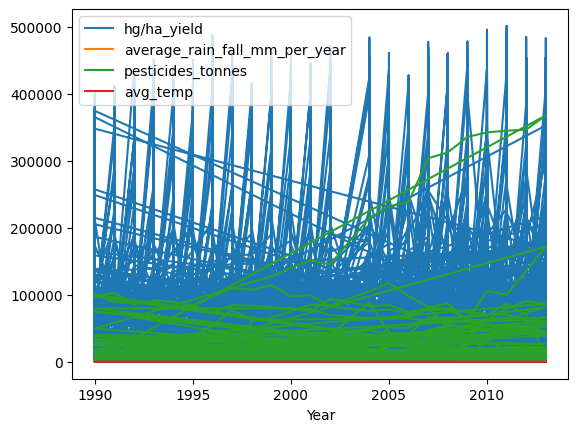

In [11]:
dataset.plot(x='Year')

(1.0, 100.0)

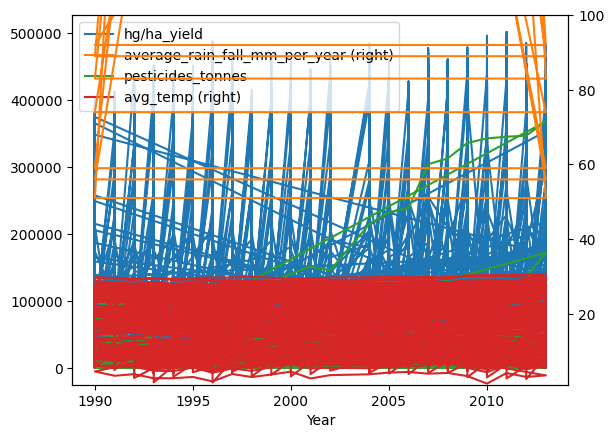

In [12]:
# Plot all variables against time
ax = dataset.plot.line(secondary_y=['avg_temp','average_rain_fall_mm_per_year'], x='Year', rot=0)
ax.right_ax.set_ylim(1,100)

array([[<AxesSubplot: title={'center': 'Year'}>,
        <AxesSubplot: title={'center': 'hg/ha_yield'}>],
       [<AxesSubplot: title={'center': 'average_rain_fall_mm_per_year'}>,
        <AxesSubplot: title={'center': 'pesticides_tonnes'}>],
       [<AxesSubplot: title={'center': 'avg_temp'}>, <AxesSubplot: >]],
      dtype=object)

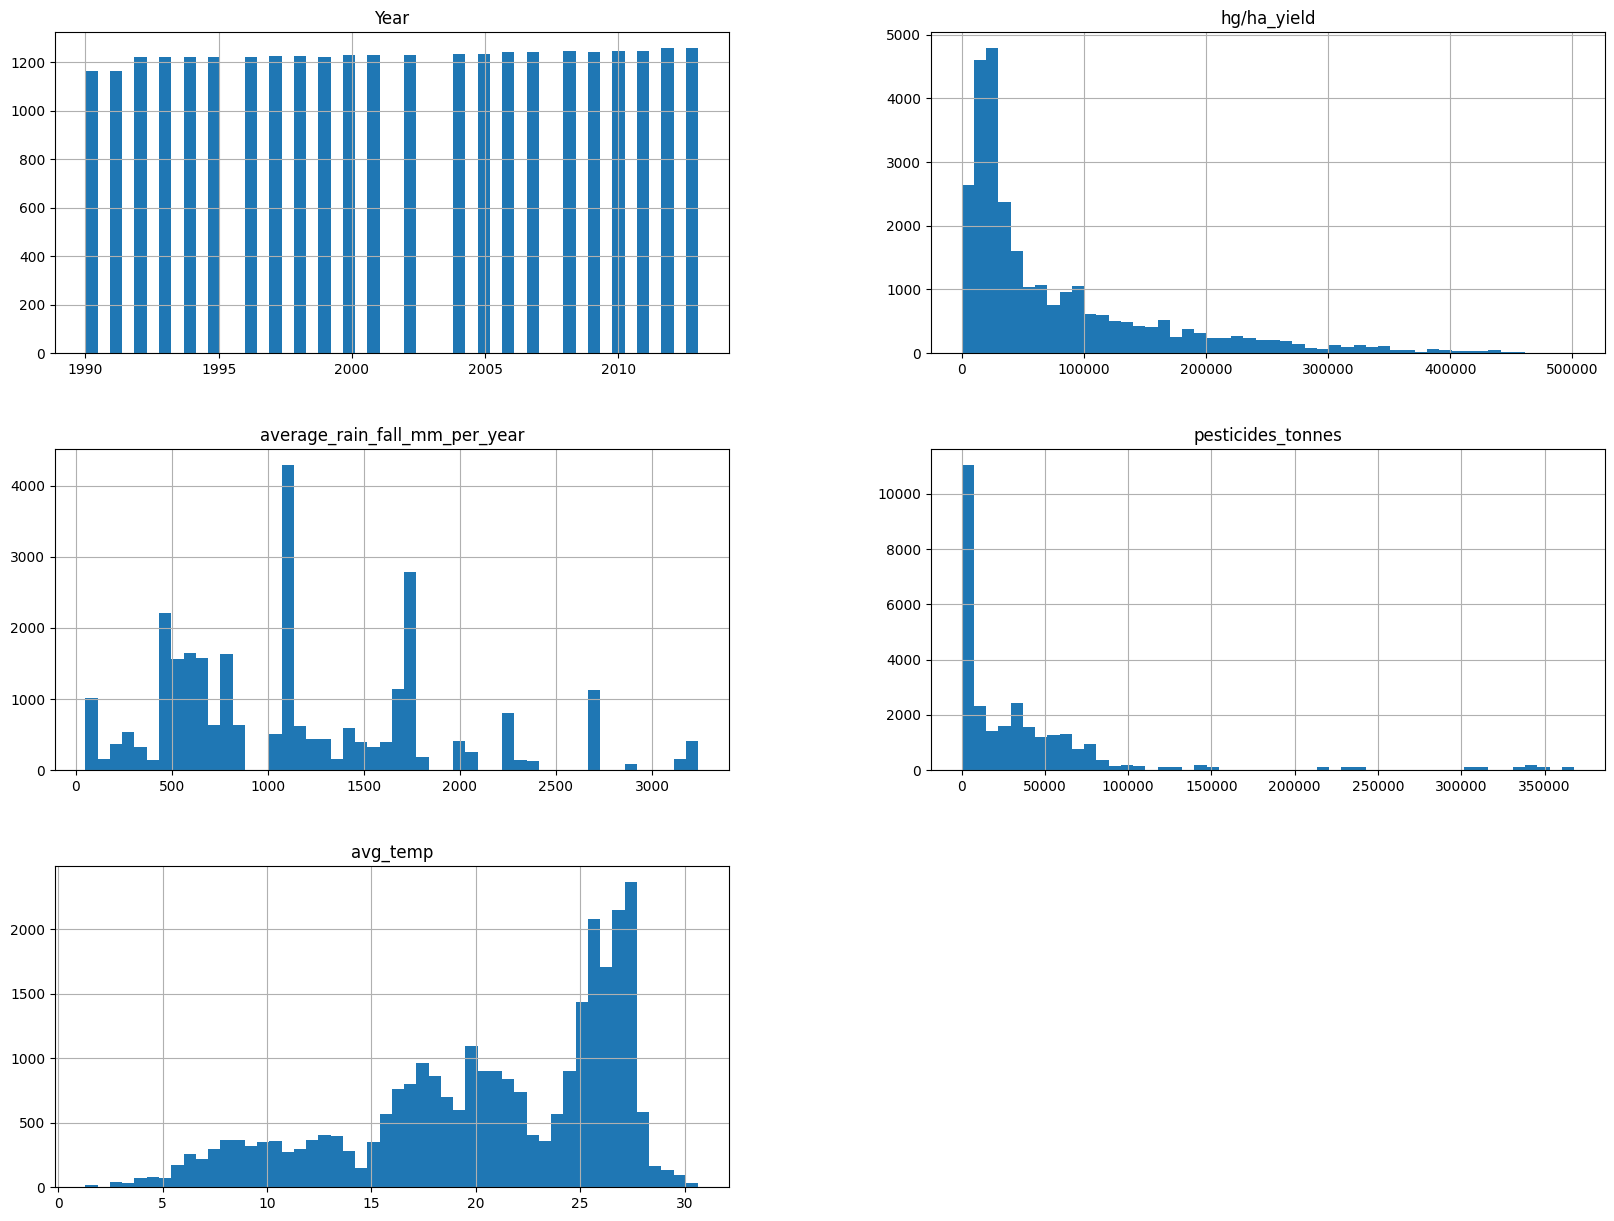

In [13]:
#Plot histograms of all the variables in the dataset
dataset.hist(bins=50, figsize = (20,15))

#### 04. Correlation matrix

<AxesSubplot: >

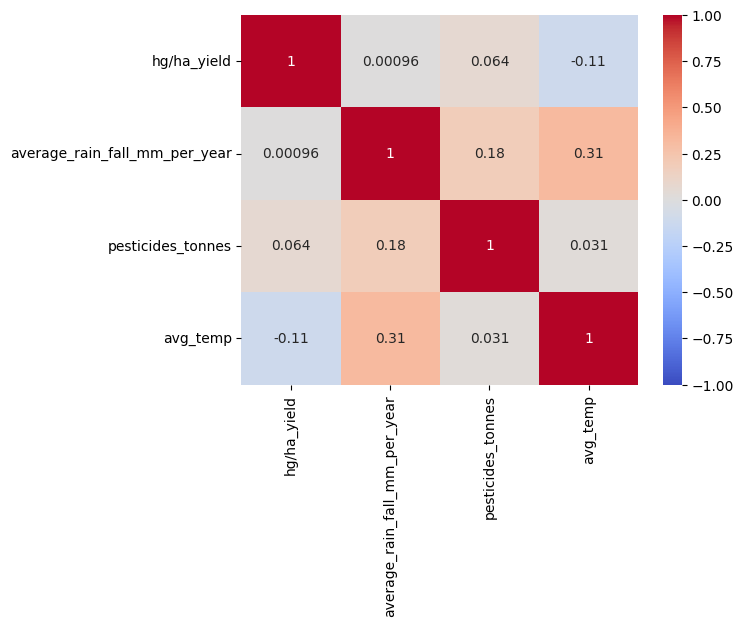

In [14]:
# Correlation data 
corr = dataset.drop('Year', axis=1).corr()

# Correlation matrix with seaborn (correlation val are -1 to 1, thats why vmin vmax)
sns.heatmap(corr, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

# Functions

#### Checking Parameters

In [15]:
def parameter_check_class(pred, labels_test, features_test):
    """Determines R2, MAE, RMSE and Adjusted R2 by CLASS"""
    
    # Calculate R^2 and MAE for each class
    r2_scores = {}
    mae_scores = {}
    mae_per_scores = {}
    
    # Reconvert Items feature into a categorical variable
    item_cols = [col for col in features_test.columns if col.startswith('Item_')]
    features_test['Items'] = features_test[item_cols].idxmax(axis=1).str.replace('Item_', '')
    # Drop the one-hot encoded columns
    features_test.drop(item_cols, axis=1, inplace=True)
    
    # Reset index so they match
    features_test = features_test.reset_index(drop=True)
    labels_test = labels_test.reset_index(drop=True)
    
    print('\n')
    # Group features by crop type
    for crop, group in features_test.groupby(['Items']):
        idx = group.index.tolist()
        y_true = labels_test.loc[idx].to_numpy()
        r2 = r2_score(y_true, pred[idx])
        mae = mean_absolute_error(y_true, pred[idx])

        # Calculate the percentage mae
        target_range = max(y_true) - min(y_true)
        percentage_mae = (mae / target_range) * 100

        mae_per_scores[crop] = percentage_mae
        r2_scores[crop] = r2
        mae_scores[crop] = mae

        # print the results
        print(f"{crop}: R^2={r2:.2f}, MAE={mae:.2f}, MAE%={percentage_mae:.2f}%")

    return { 'r2': r2_scores, 'mae':mae_scores, 'mae%': mae_per_scores}

In [16]:
def parameter_check(pred, labels_test):
    """Determines r2, mae, rmse and adjusted r2"""

    # Calculate R-squared
    r2 = r2_score(labels_test , pred)
    print(f"R^2: {r2:.3f}")

    # Calculate MAE
    mae = mean_absolute_error(labels_test, pred)
    print(f"MAE: {mae:.3f}")

    # calculate the percentage mae
    target_range = max(labels_test) - min(labels_test)
    percentage_mae = (mae / target_range) * 100
    print(f"MAE(%): {percentage_mae:.2f}%")

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(labels_test, pred))
    print(f"RMSE {rmse:.3f}")

    # Calculate Adjusted R-squared
    n = len(labels_test)
    p = len(pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f"Adjusted R^2 {adj_r2:.3f}")

    return { 'r2': r2, 'mae':mae, 'rmse':rmse, 'adj_r2':adj_r2, 'mae%': percentage_mae}

In [17]:
def plot_learning_curves(best_model, features_train, labels_train, cv):
    """Plot the learning curve of a model"""
    
    train_sizes, train_scores, val_scores = learning_curve(best_model, features_train, labels_train, 
                cv=cv, n_jobs=-1, shuffle=True, random_state=42)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                    val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Train")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g",
            label="Val")

    plt.legend(loc="best")
    plt.show()

### Hyperparameters

In [18]:
# Parameter grids to search over using gridsearch (for each algorithm)
params = {
'svm' : {
    'rgs__degree':[0.01, 0.1, 1, 10],
    # 'rgs__gamma' : [1,3,5],
    # 'rgs__kernel' :['rbf', 'linear', 'poly' ,'sigmoid'],
    # 'rgs__C' : [10, 100],
    # 'rgs__coef0': [0.01, 10, 0.5],
    # 'rgs__epsilon': [0.1, 0.5, 1],
},
'rf': {
    'rgs__n_estimators':[5, 10, 50,],
    'rgs__max_depth': [5, 10, 20],
    'rgs__min_samples_split': [2,3,4],
    'rgs__min_samples_leaf': [3,5]
},
'ada':{
    'rgs__n_estimators':[10, 50, 100, 500],
    'rgs__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
},
'elastic':{
    'rgs__alpha':[0.01, 0.1, 1.0, 2,0, 10.0,],
    'rgs__l1_ratio':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
},
'xgb':{
    'rgs__n_estimators': [100,250,400],
    'rgs__max_depth': [3, 6, 9],
    'rgs__learning_rate': [0.05, 0.1, 0.20],
    'rgs__min_child_weight': [1, 10, 100]
    
},
'sgdr' : {
    'rgs__alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
    'rgs__l1_ratio':np.arange(0, 1, 0.1),

},
'lgbmr' : {
    'rgs__n_estimators': [50, 100, 400],
    'rgs__max_depth': [-1, 0, 1],
    'rgs__learning_rate': [0.05, 0.1, 0.20],
    'rgs__min_child_weight': [0.001, 0.01, 0.1]
    
}
}

### Pipeline

In [19]:
def build_pipeline(params, regressor, features_train, labels_train, features_test, labels_test):
    # Setting up a pipeline
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('imputer', None),
        ('balancing', None),
        ('rgs', regressor)
    ])

    # Cross validation
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

    # Set up the grid search
    gs = GridSearchCV(estimator=pipe,param_grid=params,n_jobs=-1, verbose=10, cv=cv,scoring='r2')

    # Fit gs to training data
    gs_results = gs.fit(features_train, labels_train)

    # Plot learning curves
    # Join test and train
    plot_learning_curves(gs.best_estimator_, features_train, labels_train, cv)
    
    # Find best fit
    print(f'Best score: {gs_results.best_score_}')
    print(f'Best parameters: \n{gs_results.best_params_}')

    # Get score
    print(f'\nScore: {gs.score(features_test, labels_test)}')

    # Predict results
    labels_preds = gs.predict(features_test)
    best_par = parameter_check(labels_preds, labels_test)
    best_par_class = parameter_check_class(labels_preds, labels_test, features_test)
    
    return best_par, best_par_class, gs_results 

# Data Preprocessing

### 04. Handle Categorical Variables

In [20]:
# Handle categorical variables
# OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# fit and transform the categorical data in Area and Item
encoded_data = encoder.fit_transform(dataset[['Item', 'Area']])

# convert the encoded data back into a Pandas DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['Item', 'Area']))
df = pd.concat([dataset, encoded_df], axis=1)

In [21]:
# Turn yield into logaritmic
df['Log_Yield'] = np.log(df['hg/ha_yield'])

### 05. Remove Unnecesary Features

In [22]:
# Create features and labels (and remove categorical variables)
features = df.drop(['hg/ha_yield','Log_Yield','Item','Area', 'Year'], axis=1)
labels = df['Log_Yield']

### 06. Split Dataset

In [23]:
# Create training (75%) and test (25%) sets
features_train, features_test , labels_train , labels_test = train_test_split(features, labels, test_size =0.2, random_state=42)
# features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

print(f'Train: {len(features_train)} features, {len(labels_train)} labels\
      \nTest: {len(features_test)} features, {len(labels_test)} labels')
    # \nVal: {len(features_val)} features, {len(labels_val)} labels\')

Train: 22593 features, 22593 labels      
Test: 5649 features, 5649 labels


# Model Comparison

### 06. Run Models

Random Forest

Fitting 15 folds for each of 54 candidates, totalling 810 fits


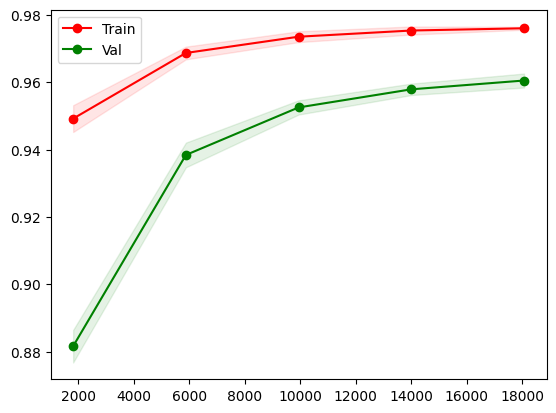

Best score: 0.9607573013705083
Best parameters: 
{'rgs__max_depth': 20, 'rgs__min_samples_leaf': 3, 'rgs__min_samples_split': 3, 'rgs__n_estimators': 50}

Score: 0.9655357980427266
R^2: 0.966
MAE: 0.122
MAE(%): 1.57%
RMSE 0.206
Adjusted R^2 195.654


Cassava: R^2=0.93, MAE=0.09, MAE%=2.67%
Maize: R^2=0.87, MAE=0.20, MAE%=3.98%
Plantains and others: R^2=0.91, MAE=0.11, MAE%=3.79%
Potatoes: R^2=0.91, MAE=0.09, MAE%=2.49%
Rice, paddy: R^2=0.90, MAE=0.11, MAE%=2.95%
Sorghum: R^2=0.90, MAE=0.14, MAE%=2.81%
Soybeans: R^2=0.88, MAE=0.10, MAE%=1.80%
Sweet potatoes: R^2=0.91, MAE=0.09, MAE%=2.37%
Wheat: R^2=0.88, MAE=0.16, MAE%=4.24%
Yams: R^2=0.93, MAE=0.06, MAE%=2.48%


In [24]:
best_par_rf, best_par_rf_class, score_rf = build_pipeline(params['rf'], RandomForestRegressor(), features_train, labels_train, features_test, labels_test)

SVM

Fitting 15 folds for each of 4 candidates, totalling 60 fits


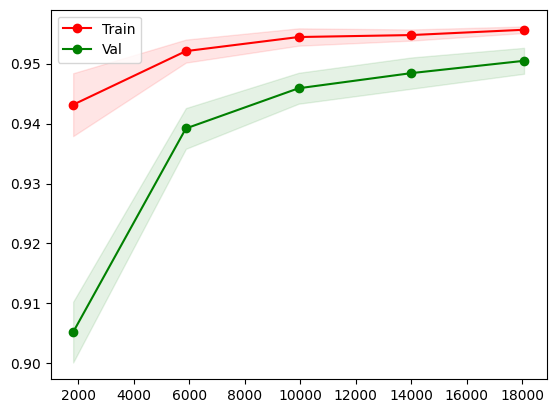

Best score: 0.9504666631198522
Best parameters: 
{'rgs__degree': 1}


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Items
Feature names seen at fit time, yet now missing:
- Item_Cassava
- Item_Maize
- Item_Plantains and others
- Item_Potatoes
- Item_Rice, paddy
- ...


In [25]:
best_par_svm, best_par_svm_class, score_svm = build_pipeline(params['svm'], SVR(), features_train, labels_train, features_test, labels_test)

AdaBoost

Fitting 3 folds for each of 20 candidates, totalling 60 fits


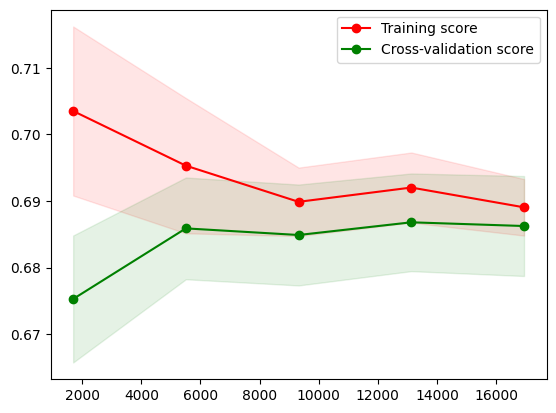

Best score: 0.6863719630887379
Best parameters: 
{'rgs__learning_rate': 0.01, 'rgs__n_estimators': 100}

Score: 0.6744263243974616
R^2: 0.6744263243974616
MAE: 33171.09245122074
MAE(%): 6.872003557335056
RMSE: 48283.545010405884
Adjusted R^2: 2299.550149753921


In [ ]:
best_par_ada, best_par_ada_class, score_ada = build_pipeline(params['ada'], AdaBoostRegressor(), features_train, labels_train, features_test, labels_test)

Elastic Net

Fitting 3 folds for each of 42 candidates, totalling 126 fits


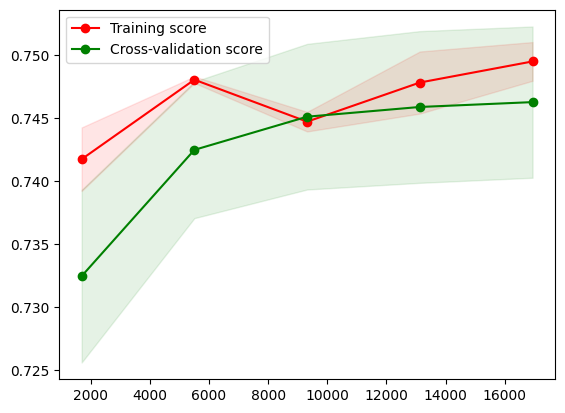

Best score: 0.7458218562382939
Best parameters: 
{'rgs__alpha': 0, 'rgs__l1_ratio': 0.1}

Score: 0.7464210605410286
R^2: 0.7464210605410286
MAE: 29617.665347145055
MAE(%): 6.135845598840076
RMSE: 42611.91951757387
Adjusted R^2: 1791.2673125803378


In [ ]:
best_par_elastic, best_par_elastic_class, score_elastic = build_pipeline(params['elastic'], ElasticNet(), features_train, labels_train, features_test, labels_test)

X-Gradient Boost

Fitting 3 folds for each of 81 candidates, totalling 243 fits


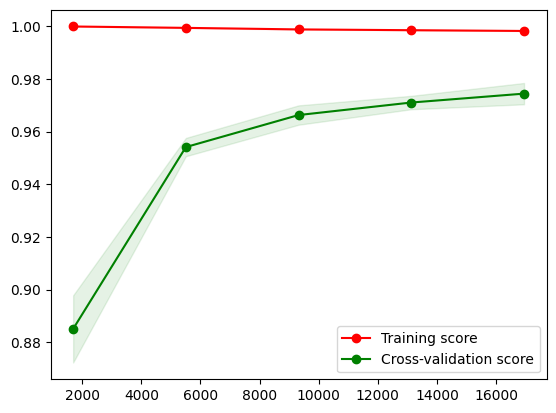

Best score: 0.9717612566169701
Best parameters: 
{'rgs__learning_rate': 0.2, 'rgs__max_depth': 9, 'rgs__min_child_weight': 1, 'rgs__n_estimators': 400}

Score: 0.9742912024634117
R^2: 0.9742912024634117
MAE: 5863.302865285945
MAE(%): 1.2146913221875217
RMSE: 13567.986086345563
Adjusted R^2: 182.50411060831325


In [ ]:
best_par_xgb, best_par_xgb_class, score_xgb = build_pipeline(params['xgb'], XGBRegressor(), features_train, labels_train, features_test, labels_test)

SGDR Regressor

Fitting 3 folds for each of 90 candidates, totalling 270 fits


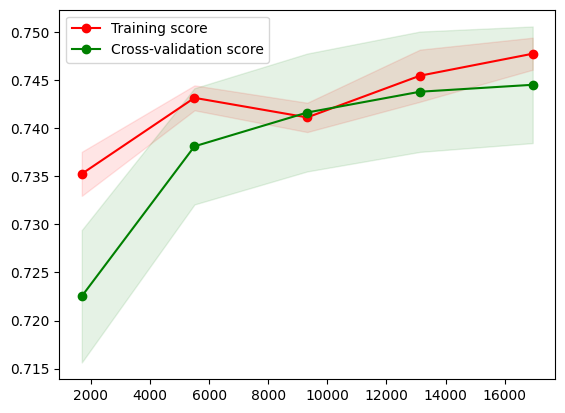

Best score: 0.7442249618046045
Best parameters: 
{'rgs__alpha': 1e-05, 'rgs__l1_ratio': 0.4}

Score: 0.7451050770092117
R^2: 0.7451050770092117
MAE: 29619.324538357883
MAE(%): 6.136189330899356
RMSE: 42722.34670507975
Adjusted R^2: 1800.5581563149653


In [ ]:
best_par_sgdr, best_par_sgdr_class, score_sgdr = build_pipeline(params['sgdr'], SGDRegressor(), features_train, labels_train, features_test, labels_test)

LGBM Regressor

Fitting 3 folds for each of 81 candidates, totalling 243 fits


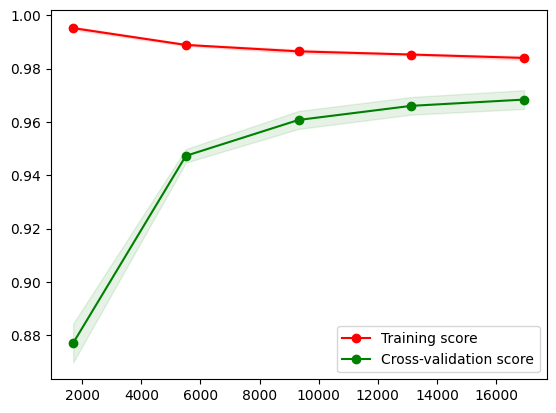

Best score: 0.9665756324671392
Best parameters: 
{'rgs__learning_rate': 0.2, 'rgs__max_depth': -1, 'rgs__min_child_weight': 0.001, 'rgs__n_estimators': 400}

Score: 0.9703084036714762
R^2: 0.9703084036714762
MAE: 7573.619960333184
MAE(%): 1.5690150508563687
RMSE: 14581.133332364809
Adjusted R^2: 210.62267007937808


In [ ]:
best_par_lgbmr, best_par_sgdr_class, score_lgbmr = build_pipeline(params['lgbmr'], LGBMRegressor(), features_train, labels_train, features_test, labels_test)

### 07. Comparison

#### Parameter Comparison

In [ ]:
# Plot out different parameters
compare = [best_par_svm, best_par_rf, best_par_ada, best_par_elastic, best_par_xgb, best_par_sgdr, best_par_lgbmr ]
headers_comparison = ['SVM','RandomForest','AdaBoost', 'ElasticNet', 'XGradBoost', 'SGDR', 'LGBMR']

In [ ]:
compare_df = pd.DataFrame(compare)
compare_df["results"]=headers_comparison
compare_df = compare_df.set_index('results', drop=True).rename_axis(None)
compare_df

,r2,mae,rmse,adj_r2,mae%
SVM,0.384689,35902.543553,66377.627146,4345.093184,7.437874
RandomForest,0.971726,6604.371357,14228.718869,200.612293,1.368217
AdaBoost,0.674426,33171.092451,48283.545010,2299.550150,6.872004
ElasticNet,0.746421,29617.665347,42611.919518,1791.267313,6.135846
XGradBoost,0.974291,5863.302865,13567.986086,182.504111,1.214691
SGDR,0.745105,29619.324538,42722.346705,1800.558156,6.136189
LGBMR,0.970308,7573.619960,14581.133332,210.622670,1.569015


ANALYSIS: XGradBoost has great r2 and the lowest mae, so we'll be using that.

In [ ]:
# compare_df = compare_df.drop(['SGDR'])
compare_df = compare_df.T
compare_df

,SVM,RandomForest,AdaBoost,ElasticNet,XGradBoost,SGDR,LGBMR
r2,0.384689,0.971726,0.674426,0.746421,0.974291,0.745105,0.970308
mae,35902.543553,6604.371357,33171.092451,29617.665347,5863.302865,29619.324538,7573.619960
rmse,66377.627146,14228.718869,48283.545010,42611.919518,13567.986086,42722.346705,14581.133332
adj_r2,4345.093184,200.612293,2299.550150,1791.267313,182.504111,1800.558156,210.622670
mae%,7.437874,1.368217,6.872004,6.135846,1.214691,6.136189,1.569015


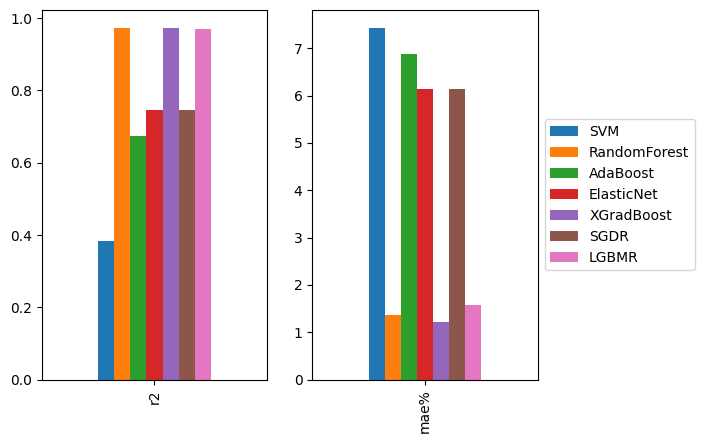

In [ ]:
import matplotlib.pyplot as plt

#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2)

#add DataFrames to subplots
compare_df.loc[pd.CategoricalIndex(['r2'])].plot(kind='bar', ax=axes[0], legend=False)
compare_df.loc[pd.CategoricalIndex(['mae%'])].plot(kind='bar', ax=axes[1]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))



#### Score Comparison

In [ ]:
def get_scores(gs_results):
    """Return hs_results in dictionary"""
    return {
        'Best Score' : gs_results.best_score_,
        'Best parameters': gs_results.best_params_,
        'Means' : gs_results.cv_results_['mean_test_score'],
        'Stds' : gs_results.cv_results_['std_test_score'],
        'Params' : gs_results.cv_results_['params']
        }

In [ ]:
# Plot out different parameters
score_objects = [score_svm, score_rf, score_ada, score_elastic, score_xgb, score_sgdr, score_lgbmr ]
compare2 = [ get_scores(x) for x in score_objects  ]

compare_df2 = pd.DataFrame(compare2)
compare_df2["results"]=headers_comparison
compare_df2 = compare_df2.set_index('results', drop=True).rename_axis(None)

In [ ]:
compare_df2

,Best Score,Best parameters,Means,Stds,Params
SVM,0.266753,"{'rgs__C': 100, 'rgs__epsilon': 0.1}","[-0.1456587182445089, -0.14565744316022103, -0...","[0.0036934020432339847, 0.0036917356428929236,...","[{'rgs__C': 10, 'rgs__epsilon': 0.1}, {'rgs__C..."
RandomForest,0.968003,"{'rgs__max_depth': 20, 'rgs__min_samples_leaf'...","[0.8123972853621394, 0.8169707834536499, 0.817...","[0.005537655221578641, 0.008127709766115258, 0...","[{'rgs__max_depth': 5, 'rgs__min_samples_leaf'..."
AdaBoost,0.686372,"{'rgs__learning_rate': 0.01, 'rgs__n_estimator...","[0.68501341708274, 0.6833702739023932, 0.68077...","[0.0059491034444962634, 0.003961444445741174, ...","[{'rgs__learning_rate': 0.0001, 'rgs__n_estima..."
ElasticNet,0.745822,"{'rgs__alpha': 0, 'rgs__l1_ratio': 0.1}","[0.7077362937003263, 0.711208752775717, 0.7148...","[0.005577876718856094, 0.005610300910812947, 0...","[{'rgs__alpha': 0.01, 'rgs__l1_ratio': 0.1}, {..."
XGradBoost,0.971761,"{'rgs__learning_rate': 0.2, 'rgs__max_depth': ...","[0.82114763414052, 0.8692953575880376, 0.88849...","[0.005490599704406633, 0.002583495253709756, 0...","[{'rgs__learning_rate': 0.05, 'rgs__max_depth'..."
SGDR,0.744225,"{'rgs__alpha': 1e-05, 'rgs__l1_ratio': 0.4}","[0.7438572806410323, 0.7442131512836522, 0.743...","[0.006714340509372654, 0.006843370446190836, 0...","[{'rgs__alpha': 1e-05, 'rgs__l1_ratio': 0.0}, ..."
LGBMR,0.966576,"{'rgs__learning_rate': 0.2, 'rgs__max_depth': ...","[0.8934340956832276, 0.9307113073050686, 0.956...","[0.0016641955258550158, 0.0025277394928342927,...","[{'rgs__learning_rate': 0.05, 'rgs__max_depth'..."


In [ ]:
# compare_df2['Best Score'].T.iplot(kind='bar')

In [ ]:
def plot_box(data):
    plot = px.Figure()

    for i,each in enumerate(data.to_list()):
        plot.add_trace(px.Box(y=each, boxmean=True, name=headers_comparison[i]))

    # plot.update_layout(template='plotly_dark', title="Algorthm Comparison")
    plot.show()

In [ ]:
plot_box(compare_df2['Stds'])

In [ ]:
plot_box(compare_df2['Means'])

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed